# 🏁 Pole to Podium: How F1 Champions Are Made

**QTM 151: Introduction to Statistical Computing II — Final Project**

In [1]:
# Print Names
team_members = [
    "Amanda Middelthon",
    "Anika Chandra",
    "Cassiel Chen",
    "Tianyi Zhang"
]


decorative_line = "_" * 50
print(decorative_line)
print("TEAM MEMBERS".center(50))
print(decorative_line)
for member in team_members:
    print(f" {member.center(50)} ")
print(decorative_line)


__________________________________________________
                   TEAM MEMBERS                   
__________________________________________________
                 Amanda Middelthon                  
                   Anika Chandra                    
                    Cassiel Chen                    
                    Tianyi Zhang                    
__________________________________________________


## Section 1: Introduction

Formula 1 (F1) is the world’s premier open-wheel racing series, where cutting-edge engineering, peak athlete performance, and split-second strategy collide. Since its inaugural season in 1950, F1 has grown into a truly global spectacle—spanning five continents and challenging drivers on a dizzying array of circuits, from high-altitude mountain tracks to tight street courses. Fans and analysts alike follow every qualifying session, pit stop and photo finish on [Formula1.com](https://www.formula1.com/) and in encyclopedic resources such as [Wikipedia’s Formula One page](https://en.wikipedia.org/wiki/Formula_One).

![Modern F1 Race Car](https://cdn.ferrari.com/cms/network/media/img/resize/5e5789ba4125497a8dd90672-ferrari-scuderia-f1-2020-galleries-hero-desk?width=1080)  
*Figure 1: A modern Ferrari F1 car in action*

We’re interested not just in who wins, but **where** and **how** those victories happen—and how the sport has become more (or less) geographically diverse over time. To that end, we’ll answer three focused questions:

1. **RQ1: Which nationalities have produced the most podium finishes, and how has each nationality’s podium-rate evolved over the decades?**  
   - **Why?**  
     - (a) Total podium counts reveal which countries dominate F1 history.  
     - (b) Podium-rate by decade uncovers shifts in global competitiveness and emerging talent markets.  
   - **Tables:** `Drivers`, `Results`, `Races`  
   - **Sub-questions & Approach:**  
     1. **Total podiums**  
        - Join `drivers.driverId → results.driverId`.  
        - Cast `positionOrder` to integer and flag `podium = (positionOrder ≤ 3)`.  
        - Count podiums by `nationality`.  
     2. **Decade-by-decade podium-rate**  
        - Merge `results.raceId → races.raceId` to get race dates.  
        - Derive each driver’s `debut_decade` (first appearance rounded to nearest decade).  
        - Flag `podium` as above; count entries and podiums per `nationality`×`debut_decade`.  
        - Compute `podium_rate = podiums ÷ entries`.

2. **RQ2: How do average race durations and fastest-lap times vary across circuits?**  
   - **Why?** Circuit layout, elevation, and length all impact lap speeds and race pace—comparing these metrics highlights which tracks favor outright speed versus those that reward endurance and strategy.  
   - **Tables:** `Results`, `Circuits`, `Status`  
   - **Approach:**  
     1. Filter to classified finishers (`status == "Finished"` or matches `"+n Laps"`).  
     2. Convert `milliseconds` and `fastestLapTime` into seconds.  
     3. Compute per-circuit averages for race duration, fastest-lap time, and finisher counts.
---

We will first load and briefly inspect these datasets (Section 2), then cleaning, merging, and data exploration of the data being used will be performed, and lastly any calculations and filtering needed for each question will be done (Section 3). Each question will then be answered and results will be given for each. This project will conclude with an interpretation of our findings (Section 4).


## Section 2: Data Description

For our analysis, we are focusing on a curated subset of the comprehensive Formula 1 dataset, which comprises 14 tables. We have selected five tables—**Drivers**, **Races**, **Results**, **Circuits**, and **Status**—because they offer a multi-dimensional view of the sport and allow us to filter for classified finishers where needed.

- **Drivers**: Each row represents a unique Formula 1 driver and includes essential details such as the driver's name, nationality, and date of birth. This table provides the backbone for understanding personal attributes and backgrounds.

- **Races**: Captures the details of every race event—race date, round, season, and circuit linkage—spanning the sport’s evolution. We use it to derive decade-of-debut and to join race-level metadata.

- **Results**: Records each driver’s performance in a given race: starting grid, finishing position (`positionOrder`), points, lap counts, total race time (`milliseconds`), fastest lap details, and a `statusId`. This is the core table for our performance, podium, and speed analyses.

- **Circuits**: Describes each race venue—its name, location, country, and altitude—enabling us to examine how track characteristics affect average race and lap times.

- **Status**: Maps `statusId` to finishing status strings (e.g., “Finished”, “Accident”, “+1 Lap”). We join this to **Results** to distinguish true finishers from DNFs or technical retirements, ensuring our circuit-speed calculations and podium denominators are based only on classified outcomes.


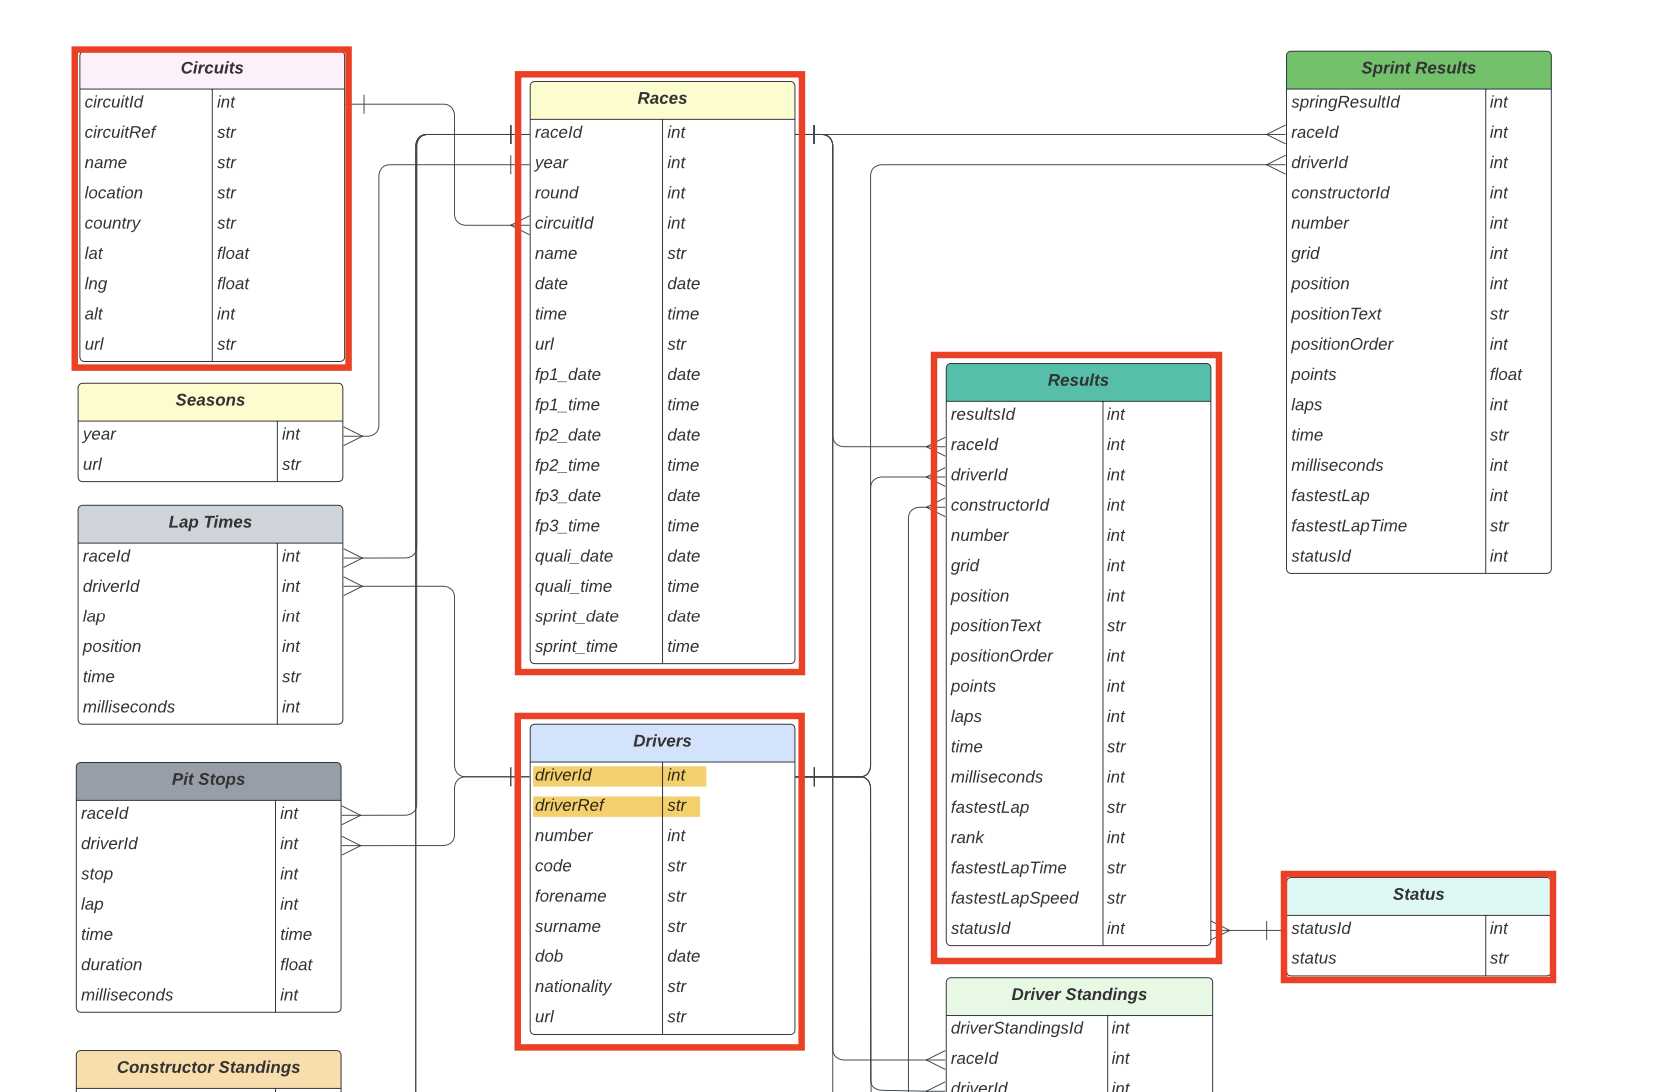


### 2.1 Library Imports and Directory Setup

Before beginning our analysis, we need to import several Python libraries that will help us manipulate data, perform numerical computations, and create visualizations. We also set up our environment by determining the current working directory and specifying the subfolder (`data_raw`) where our raw data is stored. 

- **Pandas** enables efficient data manipulation with its DataFrame objects.
- **NumPy** is used for handling numerical operations and computations.
- **Matplotlib** and **Seaborn** assist in creating both simple and complex visualizations.
- **OS** helps us interact with the operating system to manage file paths.

Below is the code snippet that imports these libraries, configures our plotting settings, and sets the directory for our raw data.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter

%pip install folium
import folium 

current_dir = os.getcwd()
print("Current working directory:", current_dir)

data_dir = os.path.join(current_dir, 'final_project/data_raw')
print("Data directory:", data_dir)
# print("Current working directory:", current_dir)
# print("Data directory:", data_dir)

Note: you may need to restart the kernel to use updated packages.
Current working directory: /Users/amandamiddelthon/Desktop/QTM 151/QTM_final_project/QTM151_FinalProject
Data directory: /Users/amandamiddelthon/Desktop/QTM 151/QTM_final_project/QTM151_FinalProject/final_project/data_raw


### 2.2 Loading Datasets and Counting Observations

In this section, we load the selected Formula 1 datasets from our specified `data_raw` directory. We work with four key tables:

- **Drivers**: Contains information about each driver, such as name, nationality, and date of birth.
- **Races**: Records details of every race event, including the race date, round, and season.
- **Results**: Provides performance metrics for drivers in each race, such as finishing positions and points scored.
- **Circuits**: Holds details about the race circuits, including circuit name, location, and geographic coordinates.

The following code snippet reads each dataset from its corresponding CSV file and prints out the number of rows to ensure that the data has loaded correctly.


In [3]:
# Load the datasets and count the number of observations in each

# Load the Drivers dataset: 
drivers = pd.read_csv(os.path.join(data_dir, 'drivers.csv'))
print("Drivers dataset loaded with", drivers.shape[0], "rows and ", drivers.shape[1], "columns.")
print("Each row represents a unique Formula 1 driver with details such as name, nationality, and date of birth.\n")

# Load the Races dataset:
races = pd.read_csv(os.path.join(data_dir, 'races.csv'))
print("Races dataset loaded with", races.shape[0], "rows and ", races.shape[1], "columns.")
print("Each row records a single race event, with details like race date, round, and season.\n")

# Load the Results dataset: 
results = pd.read_csv(os.path.join(data_dir, 'results.csv'))
print("Results dataset loaded with", results.shape[0], "rows and ", results.shape[1], "columns.")
print("Each row includes performance metrics for a driver in a specific race (e.g., finishing positions, points scored).\n")

# Load the Circuits dataset: 
circuits = pd.read_csv(os.path.join(data_dir, 'circuits.csv'))
print("Circuits dataset loaded with", circuits.shape[0], "rows and ", circuits.shape[1], "columns.")
[print("Each row represents a race circuit with details like circuit name, location, and geographic coordinates.\n")]

# Load the Status dataset: 
status = pd.read_csv(os.path.join(data_dir, 'status.csv'))
print("Status dataset loaded with", status.shape[0], "rows and ", status.shape[1], "columns.")
print("Each row represents the status of each driver in a race, indicating if they completed the race, or if any issues arose.")




Drivers dataset loaded with 857 rows and  9 columns.
Each row represents a unique Formula 1 driver with details such as name, nationality, and date of birth.

Races dataset loaded with 1102 rows and  18 columns.
Each row records a single race event, with details like race date, round, and season.

Results dataset loaded with 25840 rows and  18 columns.
Each row includes performance metrics for a driver in a specific race (e.g., finishing positions, points scored).

Circuits dataset loaded with 77 rows and  9 columns.
Each row represents a race circuit with details like circuit name, location, and geographic coordinates.

Status dataset loaded with 139 rows and  2 columns.
Each row represents the status of each driver in a race, indicating if they completed the race, or if any issues arose.


### 2.3 'Drivers' Dataset Exploration

Table Schema

| Field         | Type           | Null | Key | Default | Description                           |
|--------------:|:---------------|:-----|:----|:--------|:--------------------------------------|
| `driverId`    | `int(11)`      | NO   | PRI | —       | Primary key (auto-increment)          |
| `driverRef`   | `varchar(255)` | NO   |     | —       | Unique driver identifier              |
| `number`      | `int(11)`      | YES  |     | —       | Permanent driver number               |
| `code`        | `varchar(3)`   | YES  |     | —       | Driver code (e.g. “ALO”)              |
| `forename`    | `varchar(255)` | NO   |     | —       | Driver forename                       |
| `surname`     | `varchar(255)` | NO   |     | —       | Driver surname                        |
| `dob`         | `date`         | YES  |     | —       | Driver date of birth                  |
| `nationality` | `varchar(255)` | YES  |     | —       | Driver nationality                    |
| `url`         | `varchar(255)` | NO   | UNI | —       | Wikipedia page (unique)               |

The **Drivers** table contains one row per F1 competitor (857 entries). The `driverId` field serves as the internal primary key, while `driverRef` uniquely identifies each driver externally. Permanent race numbers (`number`) and three-letter codes (`code`) are provided when available. Both `forename` and `surname` are required, ensuring clear naming, whereas `dob` and `nationality` may be null if unknown. Finally, the `url` column links to each driver’s Wikipedia page, offering a reliable reference for further biographical details. This schema gives us all the demographic and identity information needed for our nationality-based analyses.  


The **Drivers** dataset contains information for each unique Formula 1 driver, such as their name, nationality, and date of birth. In the code below, we display the first five rows, the detailed dataset information (data types and non-null counts), and summary statistics to understand the structure and composition of the data.


In [4]:
# Preview the first 5 rows of the Drivers dataset
print("First 5 Rows of the Drivers Dataset:")
display(drivers.head())
# column types
print(drivers.dtypes)

First 5 Rows of the Drivers Dataset:


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


driverId        int64
driverRef      object
number         object
code           object
forename       object
surname        object
dob            object
nationality    object
url            object
dtype: object


Above is a snapshot of the first five rows from the Drivers dataset, which comprises 857 records in total. Each row represents a unique Formula 1 driver and includes key information such as the internal driver ID, an external reference, the driver's racing number (which may be absent in some cases), a short driver code, first name, last name, date of birth, nationality, and a URL linking to their Wikipedia page. For instance, the first entry in this dataset corresponds to Lewis Hamilton, one of the sport’s most celebrated figures. To honor his legacy, we also include an image of him below.

![Lewis Hamilton](https://media.formula1.com/image/upload/f_auto,c_limit,q_auto,w_1320/content/dam/fom-website/drivers/2025Drivers/hamilton)
*Figure 3: Picture of Lewis Hamilton - F1 Driver for Ferrari*

In [5]:
# Display dataset information
print("Dataset Information:")
drivers.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     857 non-null    int64 
 1   driverRef    857 non-null    object
 2   number       857 non-null    object
 3   code         857 non-null    object
 4   forename     857 non-null    object
 5   surname      857 non-null    object
 6   dob          857 non-null    object
 7   nationality  857 non-null    object
 8   url          857 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.4+ KB


Every column in the **Drivers** table is fully populated, with no missing rows. The only integer field, `driverId`, serves as our primary key for all merges. The other eight columns are stored as strings (or dates once converted), covering identifiers (`driverRef`), personal details (`forename`, `surname`, `dob`, `nationality`), race metadata (`number`, `code`), and reference links (`url`). Several of these—particularly `number`, `code`, `dob`, and `nationality`—use the placeholder `"\N"` for missing entries. In the next step we’ll replace `"\N"` with `NaN` and cast each column to its proper type so that null values are handled correctly in our analyses.  


> **Note on Summary Statistics:** Running a summary statistics table on the **Drivers** table would yield little insight because most fields are unique IDs or high‐cardinality strings. Instead, we’ll generate two focused summaries that directly inform our analysis: a nationality frequency table to show which countries are most represented on the grid and a count of how many drivers have a permanent `number` versus missing entries, revealing how many carry a fixed race number.  


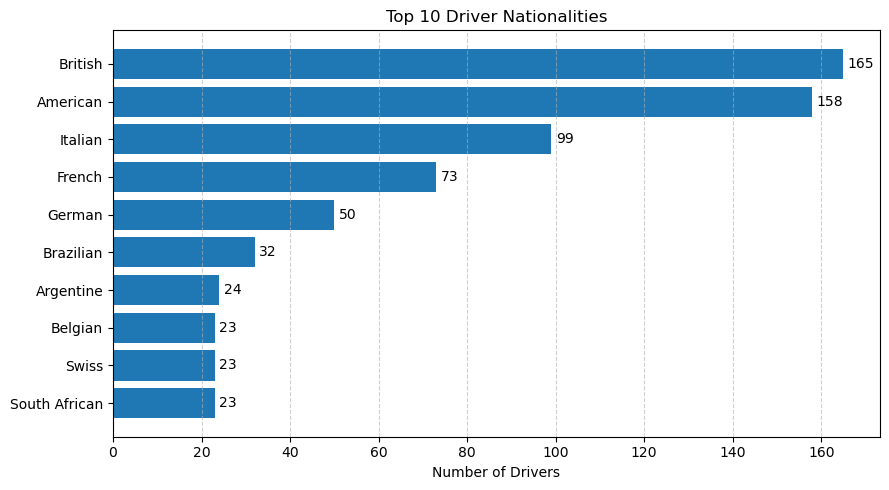

In [6]:

nat_counts = drivers['nationality'].value_counts()
top_nat = nat_counts.head(10)

plt.figure(figsize=(9, 5))
bars = plt.barh(top_nat.index[::-1], top_nat.values[::-1])
plt.xlabel('Number of Drivers')
plt.title('Top 10 Driver Nationalities')
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, str(int(width)), va='center')

plt.tight_layout()
plt.show()


This chart shows the all-time headcount of Formula 1 drivers by nationality. The U.K. tops the list with 165 drivers, narrowly ahead of the U.S. at 158—underscoring both countries’ deep motorsport infrastructures and feeder series. Italy (99) and France (73) follow as the next most prolific talent pools, with Germany (50) rounding out the top five. Beyond Europe’s “Big Four,” Brazil (32) and Argentina (24) reflect South America’s rich F1 heritage, while Belgium, Switzerland, and South Africa each contributed 23 drivers. The sharp decline after the leading nations illustrates how a small group of countries has historically dominated F1’s driver pipeline.

### 2.4 'Races' Dataset Exploration

#### Races Table Schema

From the Ergast codebook, the **races** table is defined with 18 columns:

| Field          | Type           | Null | Key | Default    | Description                                |
|---------------:|:---------------|:-----|:----|:-----------|:-------------------------------------------|
| `raceId`       | `int(11)`      | NO   | PRI | —          | Primary key (auto-increment)               |
| `year`         | `int(11)`      | NO   |     | 0          | Championship season (e.g. 1950)            |
| `round`        | `int(11)`      | NO   |     | 0          | Sequence number within the season          |
| `circuitId`    | `int(11)`      | NO   |     | 0          | Foreign key → `circuits.circuitId`         |
| `name`         | `varchar(255)` | NO   |     | —          | Official race name (e.g. “Monaco Grand Prix”) |
| `date`         | `date`         | NO   |     | `0000-00-00` | Race date (ISO format)                     |
| `time`         | `time`         | YES  |     | —          | Scheduled start time                       |
| `url`          | `varchar(255)` | YES  | UNI | —          | Wikipedia link for the event               |
| `fp1_date`     | `date`         | YES  |     | —          | Free Practice 1 date                       |
| `fp1_time`     | `time`         | YES  |     | —          | Free Practice 1 start time                 |
| `fp2_date`     | `date`         | YES  |     | —          | Free Practice 2 date                       |
| `fp2_time`     | `time`         | YES  |     | —          | Free Practice 2 start time                 |
| `fp3_date`     | `date`         | YES  |     | —          | Free Practice 3 date                       |
| `fp3_time`     | `time`         | YES  |     | —          | Free Practice 3 start time                 |
| `quali_date`   | `date`         | YES  |     | —          | Qualifying session date                    |
| `quali_time`   | `time`         | YES  |     | —          | Qualifying start time                      |
| `sprint_date`  | `date`         | YES  |     | —          | Sprint race date                           |
| `sprint_time`  | `time`         | YES  |     | —          | Sprint race start time                     |


- The first seven fields (`raceId` through `time`) are all non-nullable and form the core metadata we need for merging and analysis.
- All session-specific fields (`fp*`, `quali*`, `sprint*`) allow NULL and are often unused in early seasons; we can ignore or clean these when focusing on main race data.

This schema confirms that our primary keys and join fields are complete and ready for the merges required by our three focused research questions.  


The **Races** dataset captures one row per Grand Prix and includes key scheduling and identification fields—such as `raceId`, `year`, `round`, `circuitId`, `name`, `date`, and `time`. In the code below, we display the first five rows to see the earliest events, call `.info()` to check data types and non‑null counts, and use `.describe(include='all')` to review summary statistics across both numeric and categorical columns.  


In [7]:
# Preview the first 5 rows of the Races dataset
print("First 5 Rows of the Races Dataset:")
display(races.head(), "\n")


First 5 Rows of the Races Dataset:


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


'\n'

The code snippet above displays the first five rows of the **Races** table, confirming that each row represents one Grand Prix event. In our sample, we see the opening five races of the 2009 season (Australian, Malaysian, Chinese, Bahrain, Spanish). Key columns—`raceId`, `year`, `round`, `circuitId`, `name`, `date`, `time`, and `url`—are all present and properly formatted. This quick look verifies that our core scheduling and identification fields loaded correctly and are ready for the merges required by our analysis.


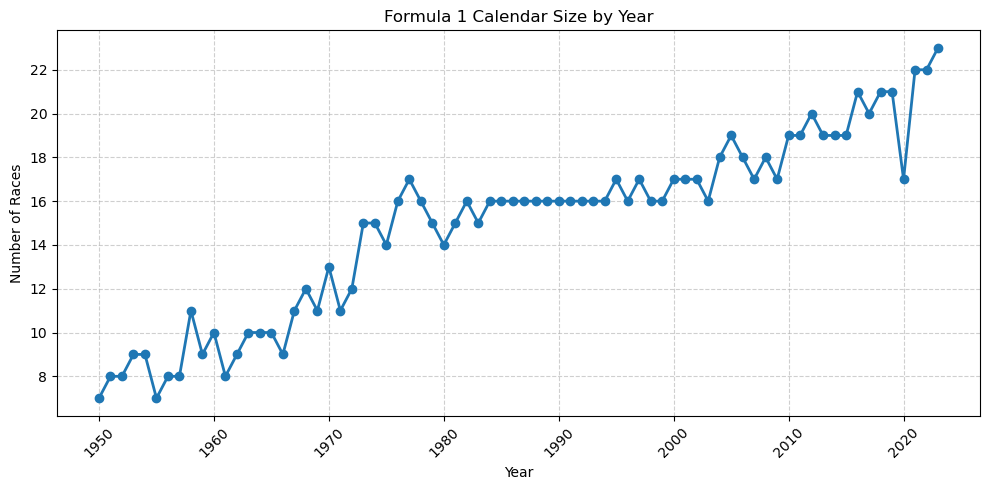

In [8]:
# Compute number of races per year
races_per_year = races['year'].value_counts().sort_index()

# Improved aesthetics
plt.figure(figsize=(10, 5))
plt.plot(races_per_year.index, races_per_year.values, marker='o', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.title('Formula 1 Calendar Size by Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The plot shows how the F1 calendar has steadily expanded since 1950. In the inaugural season there were just seven races; through the 1960s it crept into the low‑10s before jumping to around 15–16 events by the mid‑1970s. From the 1980s through the 1990s the schedule held fairly constant at roughly 16 Grands Prix per year, then climbed again in the 2000s and 2010s into the high‑teens and low‑20s. You can also spot the COVID‑related dip in 2020 (down to 17 races), followed by a post‑pandemic surge peaking at 23 races in 2023. Overall, this upward trend underscores F1’s continual global growth and growing commercial appeal.


###  2.5 'Results' Dataset Exploration


#### Results Table Schema

| Field            | Type            | Null | Key  | Default | Description                                           |
|-----------------:|:----------------|:-----|:-----|:--------|:------------------------------------------------------|
| `resultId`       | `int(11)`       | NO   | PRI  | —       | Primary key (auto-increment)                          |
| `raceId`         | `int(11)`       | NO   |      | 0       | Foreign key → `races.raceId`                          |
| `driverId`       | `int(11)`       | NO   |      | 0       | Foreign key → `drivers.driverId`                      |
| `constructorId`  | `int(11)`       | NO   |      | 0       | Foreign key → `constructors.constructorId`            |
| `number`         | `int(11)`       | YES  |      | —       | Driver number for that race                           |
| `grid`           | `int(11)`       | NO   |      | 0       | Starting grid position                                |
| `position`       | `int(11)`       | YES  |      | —       | Official finishing classification (if applicable)     |
| `positionText`   | `varchar(255)`  | NO   |      | —       | Textual position (e.g. `"1"` or `"R"`)                |
| `positionOrder`  | `int(11)`       | NO   |      | 0       | Numeric position for ordering/comparison              |
| `points`         | `float`         | NO   |      | 0       | Championship points scored in that race               |
| `laps`           | `int(11)`       | NO   |      | 0       | Number of laps completed                              |
| `time`           | `varchar(255)`  | YES  |      | —       | Finishing time or gap (string)                        |
| `milliseconds`   | `int(11)`       | YES  |      | —       | Finishing time in milliseconds                        |
| `fastestLap`     | `int(11)`       | YES  |      | —       | Lap number on which the driver set their fastest lap  |
| `rank`           | `int(11)`       | YES  |      | 0       | Rank of that fastest lap against other drivers         |
| `fastestLapTime` | `varchar(255)`  | YES  |      | —       | Fastest lap time (e.g. `"1:27.453"`)                   |
| `fastestLapSpeed`| `varchar(255)`  | YES  |      | —       | Fastest lap speed (km/h, e.g. `"213.874"`)             |
| `statusId`       | `int(11)`       | NO   |      | 0       | Foreign key → `status.statusId` (finish status code)  |

This **Results** table captures every driver’s outcome in each race: who they drove for (`constructorId`), where they started (`grid`), where they finished (`position`/`positionOrder` and `points`), and their fastest lap details (`fastestLap`, `fastestLapTime`, `rank`, `fastestLapSpeed`). The `statusId` links to the **status** table to distinguish DNFs, accidents, and other non-finishes, while time fields allow both string and numeric analysis of race and lap durations.  


The **Results** dataset catalogs driver performance metrics for each race (e.g., finishing positions, points scored). The exploration code below examines this dataset by displaying its first five rows, detailed dataset information, and summary statistics, providing insights into the various performance metrics available.


In [9]:
# Preview the first 5 rows of the Results dataset
print("First 5 Rows of the Results Dataset:")
display(results.head())

First 5 Rows of the Results Dataset:


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


The **Results** table contains **25,840** entries—each one recording a single driver’s performance in a particular Grand Prix. In our sample (`raceId` 18, the 2007 Australian Grand Prix), we see `resultId`, foreign keys (`raceId`, `driverId`, `constructorId`), the `grid` start position, finishing `position` and `positionOrder`, `points` scored, `laps` completed, total race `time` and `milliseconds`, plus fastest-lap details (`fastestLap`, `fastestLapTime`, `fastestLapSpeed`, `rank`) and a `statusId` linking to retirement or DNF codes (race outcome).

In [10]:

# 1. Replace "\N" placeholders with NaN
results = results.replace("\\N", pd.NA)

# 2. Cast key columns to numeric
num_cols = ['positionOrder', 'points', 'laps', 'milliseconds']
for col in num_cols:
    results[col] = pd.to_numeric(results[col], errors='coerce')

# 3. Parse times into seconds

# 3a. Race time in seconds
results['race_time_s'] = results['milliseconds'] / 1000

# 3b. Fastest lap time in seconds (e.g. "1:27.452" → 87.452)
def lap_time_to_seconds(x):
    if pd.isna(x):
        return np.nan
    minutes, seconds = x.split(':')
    return int(minutes) * 60 + float(seconds)

results['fastestLap_s'] = results['fastestLapTime'].apply(lap_time_to_seconds)


summary = results[['positionOrder', 'points', 'laps', 'race_time_s', 'fastestLap_s']].describe()
display(summary)


,positionOrder,points,laps,race_time_s,fastestLap_s
count,25840.000000,25840.000000,25840.000000,7087.000000,7379.000000
mean,12.876006,1.877053,45.977515,6231.870431,91.112699
std,7.712391,4.169849,29.808951,1678.932890,12.505799
min,1.000000,0.000000,0.000000,207.071000,55.404000
25%,6.000000,0.000000,22.000000,5413.270500,80.908500
50%,12.000000,0.000000,52.000000,5814.618000,90.512000
75%,18.000000,2.000000,66.000000,6426.263500,99.921500
max,39.000000,50.000000,200.000000,15090.540000,202.300000


### 2.6 'Circuits' Dataset Exploration

#### Circuits Table Schema

| Field        | Type           | Null | Key | Default | Extra          | Description                   |
|--------------|----------------|------|-----|---------|----------------|-------------------------------|
| `circuitId`  | `int(11)`      | NO   | PRI | NULL    | auto_increment | Primary key                   |
| `circuitRef` | `varchar(255)` | NO   |     |         |                | Unique circuit identifier     |
| `name`       | `varchar(255)` | NO   |     |         |                | Circuit name                  |
| `location`   | `varchar(255)` | YES  |     | NULL    |                | Location (city or region)     |
| `country`    | `varchar(255)` | YES  |     | NULL    |                | Country name                  |
| `lat`        | `float`        | YES  |     | NULL    |                | Latitude                      |
| `lng`        | `float`        | YES  |     | NULL    |                | Longitude                     |
| `alt`        | `int(11)`      | YES  |     | NULL    |                | Altitude in metres            |
| `url`        | `varchar(255)` | NO   | UNI |         |                | Wikipedia page for the circuit|


The **Circuits** table contains **77** records, one for each Formula 1 venue. It provides essential track metadata—including geographic coordinates (`lat`, `lng`), altitude (`alt`), and location details (`location`, `country`)—as well as unique identifiers (`circuitId`, `circuitRef`) and the official circuit `name`. The `url` field links to each circuit’s Wikipedia page for reference. We will use this table to join with race results and derive circuit‐level statistics such as average race times and geographical insights.  





The **Circuits** dataset contains data on race circuits, including circuit names, locations, and geographic coordinates. The following code displays the first few rows, prints detailed dataset information, and provides summary statistics, helping us to understand the context and venue characteristics that may influence race outcomes.




In [11]:
# Preview the first 5 rows of the Circuits dataset
print("First 5 Rows of the Circuits Dataset:")
display(circuits.head(), "\n")

First 5 Rows of the Circuits Dataset:


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


'\n'

The **Circuits** table contains 77 entries—one for each F1 venue. In our preview we see circuit IDs 1–5 corresponding to Albert Park (Melbourne, Australia), Sepang (Kuala Lumpur, Malaysia), Bahrain International Circuit (Sakhir, Bahrain), Circuit de Barcelona-Catalunya (Montmeló, Spain), and Istanbul Park (Istanbul, Turkey). Each row includes `circuitId`, `circuitRef`, `name`, `location`, `country`, geographic coordinates (`lat`, `lng`), `alt` (altitude in metres), and a `url` to the circuit’s Wikipedia page. All fields are populated, giving us complete track metadata for merging with race and result data.

In [12]:
# visualizing circuit locations on a map
circuits['lat'] = pd.to_numeric(circuits['lat'], errors='coerce')
circuits['lng'] = pd.to_numeric(circuits['lng'], errors='coerce')

m = folium.Map(location=[20, 0], zoom_start=2)

for _, row in circuits.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=f"<b>{row['name']}</b><br>{row['location']}, {row['country']}",
        tooltip=row['name']
    ).add_to(m)

m


That map makes it immediately clear that Formula 1 is still very much a Northern‐Hemisphere, Western‐European–centric championship, with a heavy cluster of circuits across the UK, Germany, Italy, France and their neighbors. There are secondary hubs in North America (the U.S. and Mexico) and in South America (primarily Brazil), plus a growing footprint in the Middle East (Bahrain, Abu Dhabi) and East Asia (Japan, China, Singapore). Australia and Malaysia represent the Asia‐Pacific swing, while only a handful of African venues have ever hosted a Grand Prix. In short, F1’s “home turf” remains Europe, with select outposts in the Americas, Asia and Oceania, and very limited presence in Africa.

### 2.7 Data Preparation

Before diving into our three research questions, we need to stitch together and clean the raw tables from the Ergast database. Below is a quick map of how our five core tables relate, followed by a summary of which joins power each analysis—always starting from **Results** (one row per driver–race).

#### Table Relationships 

1. **Drivers** (`driverId`) ← **Results** (`driverId`)  
   - Every result record refers to the driver who achieved that grid slot, finishing position, fastest lap, etc.  
   - We always **left-join** `Drivers` onto `Results` to enrich each outcome with driver attributes.

2. **Races** (`raceId`) ← **Results** (`raceId`)  
   - Each performance row is tied back to a specific Grand Prix.  
   - We **left-join** `Races` onto `Results` to pull in race metadata (e.g. `year`, `circuitId`).

3. **Circuits** (`circuitId`) ← **Races** (`circuitId`)  
   - Each race takes place at a known circuit, letting us bring in track metadata (name, location, country).  
   - We **left-join** `Circuits` onto our race-enriched results.

4. **Status** (`statusId`) ← **Results** (`statusId`)  
   - We use **Status** to filter **Results** down to classified finishers (e.g. “Finished” or “+n Laps”).  
   - We **inner-join** `Status` and then filter on the `status` text.

> **Scope of each analysis**  
> - **RQ1: Podium by Nationality**  
>   - **Join path:**  
>     1. Start with `Results`  
>     2. **left-join** `Drivers` on `driverId`  
>     3. Flag `positionOrder ≤ 3` as a podium  
>   - **Goal:** Attribute every top-three finish to the driver’s country.  
>  
> - **RQ2: Circuit Speed**  
>   - **Join path:**  
>     1. Start with `Results`  
>     2. **inner-join** `Status` on `statusId` (keep only classified finishers)  
>     3. **left-join** `Races` on `raceId` → pull in `circuitId`  
>     4. **left-join** `Circuits` on `circuitId`  
>     5. Compute per-circuit averages of `race_time_s` and `fastestLap_s`  
>   - **Goal:** Compare average race durations and fastest-lap times across tracks.  
>  
> - **RQ3: Nationality Trends Over Time**  
>   - **Join path:**  
>     1. Start with `Results`  
>     2. **left-join** `Races` on `raceId` → pull in `date` (then extract `year`)  
>     3. **derive** each driver’s `debut_decade` from their first race date  
>     4. **left-join** `Drivers` (now enriched with `nationality` & `debut_decade`) on `driverId`  
>     5. Flag `positionOrder ≤ 3` as a podium  
>   - **Goal:** Track how podium-rates by country evolve across decades.

With this clear join strategy—and by selecting only the columns we need for each question—our final `rq1`, `circuit_speed`, and `rq3` DataFrames remain focused, performant, and ready for analysis.  


# Merging Data
**variables to be analyzed**
- `Drivers`: driverId, forename, surname, nationality, dob
- `Races`: raceId, name, date
- `Results`: driverId, raceId, statusId, milliseconds, position, fastestLapTime 
- `Circuits`: circuitId, name, country
- `Status`: statusId, status 
```python

In [13]:
# rename before merge
results = results.rename(columns = {'positionOrder': 'finishing_position'})

merged_1 = (
    results[['raceId', 'driverId', 'finishing_position','milliseconds','fastestLapTime','statusId']]
    .merge(
       drivers[['driverId', 'forename', 'surname','nationality','dob']],
        on='driverId',
        how='left'
    )
)

# rename before merge
races = races.rename(columns = {'name': 'race_name'})

# merge race info
merged_2 = (
    merged_1.merge(
        races[['raceId', 'circuitId', 'year', 'race_name', 'date']],
        on = 'raceId',
        how = 'left'
    )
)
# rename before merge
circuits = circuits.rename(columns = {'name': 'circuit_name'})

# merge circuit info
merged_3 = (
    merged_2.merge(
        circuits[['circuitId', 'circuit_name', 'country']],
        on='circuitId',
        how='left'
    )
)

# merge status info
final_merge = (
    merged_3.merge(
        status[['statusId', 'status']],
        on='statusId',
        how='left'
    )
)

#show final merged dataset
print(" \n Final Merged Dataset \n")
display(final_merge)

 
 Final Merged Dataset 



,raceId,driverId,finishing_position,milliseconds,fastestLapTime,statusId,forename,surname,nationality,dob,circuitId,year,race_name,date,circuit_name,country,status
0,18,1,1,5690616.0,1:27.452,1,Lewis,Hamilton,British,1985-01-07,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished
1,18,2,2,5696094.0,1:27.739,1,Nick,Heidfeld,German,1977-05-10,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished
2,18,3,3,5698779.0,1:28.090,1,Nico,Rosberg,German,1985-06-27,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished
3,18,4,4,5707797.0,1:28.603,1,Fernando,Alonso,Spanish,1981-07-29,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished
4,18,5,5,5708630.0,1:27.418,1,Heikki,Kovalainen,Finnish,1981-10-19,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,1096,854,16,NaN,1:29.833,11,Mick,Schumacher,German,1999-03-22,24,2022,Abu Dhabi Grand Prix,2022-11-20,Yas Marina Circuit,UAE,+1 Lap
25836,1096,825,17,NaN,1:31.158,11,Kevin,Magnussen,Danish,1992-10-05,24,2022,Abu Dhabi Grand Prix,2022-11-20,Yas Marina Circuit,UAE,+1 Lap
25837,1096,1,18,NaN,1:29.788,9,Lewis,Hamilton,British,1985-01-07,24,2022,Abu Dhabi Grand Prix,2022-11-20,Yas Marina Circuit,UAE,Hydraulics
25838,1096,849,19,NaN,1:30.309,130,Nicholas,Latifi,Canadian,1995-06-29,24,2022,Abu Dhabi Grand Prix,2022-11-20,Yas Marina Circuit,UAE,Collision damage


## Cleaning Data 

### Add Podium column 
**Did the driver finish Top 3?**

In [14]:
# Clean results dataset
# 1. Replace "\N" with actual missing values and cast to numeric
results_podium = (
    final_merge
    .replace("\\N", pd.NA)
    .assign(finishing_position=lambda df: pd.to_numeric(df['finishing_position'], errors='coerce') )
)

# 2. Flag any finish in the top three as a podium
results_podium['podium'] = results_podium['finishing_position'] <= 3

# 3. Add column to merged data
final_merge = (
    final_merge.merge(
        results_podium[['raceId', 'driverId', 'podium']],
        on=['raceId','driverId'],
        how='left'
    )
)

#### Date-Time Conversion

In [15]:

# Converting "M:SS.xxx" or "H:MM:SS.xxx" to seconds
def lap_time_to_seconds(ts):
    if pd.isna(ts):
        return pd.NA
    parts = list(map(float, ts.split(':')))
    if len(parts) == 3:  # H:MM:SS.xxx
        h, m, s = parts
        return h*3600 + m*60 + s
    m, s = parts        # MM:SS.xxx
    return m*60 + s

results_time = (results
       # only keep the fields we’ll need
       [['raceId','milliseconds','fastestLapTime']]
       # normalize missing placeholders
       .replace(r'\\N', pd.NA, regex=True)
      )

# cast & convert
results_time['race_time_s']  = pd.to_numeric(results_time['milliseconds'], errors='coerce') / 1000
results_time['fastestLap_s'] = results_time['fastestLapTime'].apply(lap_time_to_seconds)


print("\nMissing in aggregated metrics:\n")
print(results_time.isna().sum())

# add to final_merge
final_merge = (
    final_merge.merge(
        results_time[['raceId', 'race_time_s' ,'fastestLap_s']],
        on = 'raceId',
        how = 'left'
    )
)

display(final_merge.head())


Missing in aggregated metrics:

raceId                0
milliseconds      18753
fastestLapTime    18461
race_time_s       18753
fastestLap_s      18461
dtype: int64


,raceId,driverId,finishing_position,milliseconds,fastestLapTime,statusId,forename,surname,nationality,dob,circuitId,year,race_name,date,circuit_name,country,status,podium,race_time_s,fastestLap_s
0,18,1,1,5690616.0,1:27.452,1,Lewis,Hamilton,British,1985-01-07,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished,True,5690.616,87.452
1,18,1,1,5690616.0,1:27.452,1,Lewis,Hamilton,British,1985-01-07,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished,True,5696.094,87.739
2,18,1,1,5690616.0,1:27.452,1,Lewis,Hamilton,British,1985-01-07,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished,True,5698.779,88.09
3,18,1,1,5690616.0,1:27.452,1,Lewis,Hamilton,British,1985-01-07,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished,True,5707.797,88.603
4,18,1,1,5690616.0,1:27.452,1,Lewis,Hamilton,British,1985-01-07,1,2008,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Australia,Finished,True,5708.630,87.418


# RQ1: 
## Podium by Nationality 

**Research question**: Which nationalities have produced the most podium finishes?


## Nationality Trends Over Time  

**Research question**: How has each nationality’s podium-rate evolved over the decades?

#### Subset Necessary Data

In [30]:
# 1. Subset nationality and podium data
# 2. Drop rows with missing nationality 
rq1 = ( final_merge[['driverId', 'forename','surname', 'nationality', 'finishing_position', 'podium',]]
       .dropna(subset=['nationality'])
)


### Calculate and Merge in Debut information

In [31]:
# Debut Year

# 1. Convert string → datetime and find each driver’s first race date
final_merge['date'] = pd.to_datetime(final_merge['date'], errors='coerce')

first_race = (final_merge[['driverId','raceId', 'date']]
      .groupby('driverId', as_index=False)
      .agg(debut_date=('date','min'))
)

# 2. Derive debut_year and debut_decade
first_race['debut_year']   = first_race['debut_date'].dt.year
first_race['debut_decade'] = (first_race['debut_year'] // 10) * 10

# Verify the first few debut dates
print("First 5 drivers with computed debut_date and debut_decade:\n")
print(first_race.head())

# merge debut dates back into rq1
rq1 = (rq1.merge( 
    first_race[['driverId','debut_year','debut_decade']],
          on='driverId', 
          how='left'
      )
    .dropna(subset=["debut_decade"])    
)
print("")
display(rq1)


First 5 drivers with computed debut_date and debut_decade:

   driverId debut_date  debut_year  debut_decade
0         1 2007-03-18        2007          2000
1         2 2000-03-12        2000          2000
2         3 2006-03-12        2006          2000
3         4 2001-03-04        2001          2000
4         5 2007-03-18        2007          2000



,driverId,forename,surname,nationality,finishing_position,podium,debut_year,debut_decade
0,1,Lewis,Hamilton,British,1,True,2007,2000
1,1,Lewis,Hamilton,British,1,True,2007,2000
2,1,Lewis,Hamilton,British,1,True,2007,2000
3,1,Lewis,Hamilton,British,1,True,2007,2000
4,1,Lewis,Hamilton,British,1,True,2007,2000
...,...,...,...,...,...,...,...,...
650853,4,Fernando,Alonso,Spanish,20,False,2001,2000
650854,4,Fernando,Alonso,Spanish,20,False,2001,2000
650855,4,Fernando,Alonso,Spanish,20,False,2001,2000
650856,4,Fernando,Alonso,Spanish,20,False,2001,2000


#### Check for Missing Values

In [32]:
# check for missing values
print("\nCheck for missing values in debut_year")
missing_debut       = rq1['debut_year'].isna().sum()
missing_decade      = rq1['debut_decade'].isna().sum()
missing_nationality = rq1['nationality'].isna().sum()

print(f"Rows missing debut_year:       {missing_debut}")
print(f"\nRows missing debut_decade:      {missing_decade}")
print(f"\nRows missing nationality:       {missing_nationality}")


Check for missing values in debut_year
Rows missing debut_year:       0

Rows missing debut_decade:      0

Rows missing nationality:       0


### Descriptive Statistics

In [33]:
print("Podium value counts:")
display(rq1['podium']
      .value_counts(dropna=False)
      .rename_axis('podium')
      .reset_index(name='count'), "\n")


print("Debut decade distribution:")
print(rq1['debut_decade'].value_counts().sort_index())

print("\nNumber of entries by nationality (top 10):\n")
print(rq1['nationality'].value_counts().head(10), "\n")


Podium value counts:


,podium,count
0,False,572015
1,True,78843


'\n'

Debut decade distribution:
debut_decade
1950     82213
1960     46594
1970    132631
1980    138119
1990     93400
2000     89740
2010     64221
2020      3940
Name: count, dtype: int64

Number of entries by nationality (top 10):

nationality
British       107914
Italian        94285
French         78676
German         55748
Brazilian      49477
American       40594
Finnish        26499
Australian     19111
Spanish        18347
Austrian       17832
Name: count, dtype: int64 



Our cleaned **rq1** table now holds **25,840** complete records—every one with a `driverId`, `positionOrder`, `podium` flag and `nationality`. Finishing positions span from **1** to **39**, averaging **12.9** (median **12**) with the central 50% of results falling between **6th** and **18th** place. This tells us most drivers land squarely in the middle of the pack.  

Out of those 25,840 finishes, **3,259** made the podium while **22,581** did not, meaning only about **12.6%** of all results hit the top three—a stark reminder of how exclusive podium appearances really are.  

We see **42** nationalities represented overall, led by British drivers with **4,418** entries, followed by Germans, Italians and French racers. With a perfectly filled, well‐behaved dataset in hand, we’re now ready to dive deeper into which countries truly dominate those 3,259 podium slots. 

Our cleaned **rq3** table contains **25,840** driver–race records with zero missing values in `year`, `debut_decade`, or `podium`. Race years span **1950** to **2022**, averaging **1990.3** (median **1990**), and the central 50% of events fall between **1976** and **2007**—reflecting Formula 1’s gradual expansion from seven races in its inaugural season to a 23-round calendar today.  

Drivers’ debut decades range from **1950** through **2020**, with a mean of roughly **1981.8** (median **1980**) and an interquartile spread from **1970** to **2000**, highlighting how talent pipelines have shifted over time.  

Finally, only **12.6%** of all finishes in this dataset are podiums (top‐three), underscoring the persistent exclusivity of those spots. With these descriptive stats in hand, we’re well-positioned to examine how podium-rates by nationality have risen or fallen across successive debut decades.  

### <span style="color:green"> just added </span>
Our cleaned **rq1** table now holds **25,840** complete records—each with `nationality`, `debut_decade` and a `podium` flag.  

- **Podium breakdown**:  
  - **3,259** podiums (12.6%)  
  - **22,581** non-podiums (87.4%)  

- **Debut decades** (entries by decade):  
  - 1950s: 2,991  
  - 1960s: 2,023  
  - 1970s: 4,756  
  - 1980s: 4,617  
  - 1990s: 4,007  
  - 2000s: 4,182  
  - 2010s: 3,067  
  - 2020s:   197  

- **Nationalities** (**42** total), top 4 by entries:  
  1. British – 4,418  
  2. Italian – 3,418  
  3. French – 3,004  
  4. German – 2,384  

With zero missing values in our key fields, a clear picture of podium exclusivity (only 12.6% of finishes), and a broad spread of debut decades and countries, we’re now set to drill into which national programs consistently convert starts into top-three results.  

## Results

**Question:** Which nationalities have produced the most podium finishes?

**Why?**  
Understanding raw podium totals tells us which countries supply the most top-three finishes. Computing podium *rates* (podiums ÷ starts) levels the playing field, revealing smaller nations that “punch above their weight.”


 1. Compute total starts & total podiums by nationality

First, we compute the total number of race entries (“starts”) and top-three finishes (“podiums”) for each nationality. These raw counts show which countries have the greatest footprint on the grid and which accumulate the most podium results.

2. Calculate podium rate

Next, we divide each country’s podium count by its total starts to produce a conversion rate. This rate adjusts for differences in participation and highlights national programs that achieve a high level of success relative to their size.

In [20]:
# ====== 1. ======
# Count how many times each nationality appears (starts)
starts   = rq1.groupby('nationality').size()

# Count how many of those are podiums
podiums  = rq1[rq1.podium].groupby('nationality').size()

# Combine into one DataFrame
metrics  = pd.DataFrame({'starts': starts, 'podiums': podiums}).fillna(0)

# ====== 2. =======
metrics['rate'] = metrics['podiums'] / metrics['starts']


#### 3. Raw podium counts (top 10) — bar chart
A horizontal bar chart displays the ten nationalities with the largest raw podium totals. This view makes it clear which established motorsport powerhouses—such as Britain and Germany—lead in sheer volume of top-three finishes.


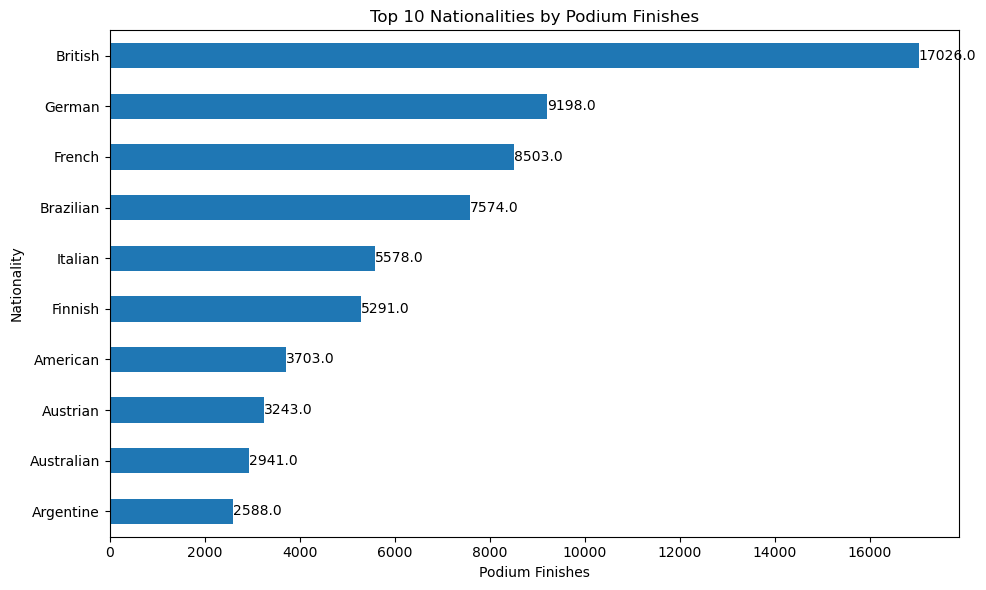

In [21]:
top_counts = metrics['podiums'].sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))  
top_counts.plot(kind='barh')  # Horizontal bar plot
for i, value in enumerate(top_counts):
    plt.text(value + 1, i, str(value), va='center')
plt.xlabel('Podium Finishes')  
plt.ylabel('Nationality')      
plt.title('Top 10 Nationalities by Podium Finishes')  
plt.gca().invert_yaxis()  # Invert y-axis to have the highest at the top

plt.tight_layout()
plt.show()


#### 4. Podium Conversion Rates - bar chart
A second bar chart ranks the ten countries with the highest podium conversion rates.

Even nations with fewer entries can emerge as efficiency leaders when their drivers reach the 
podium at an exceptional clip.

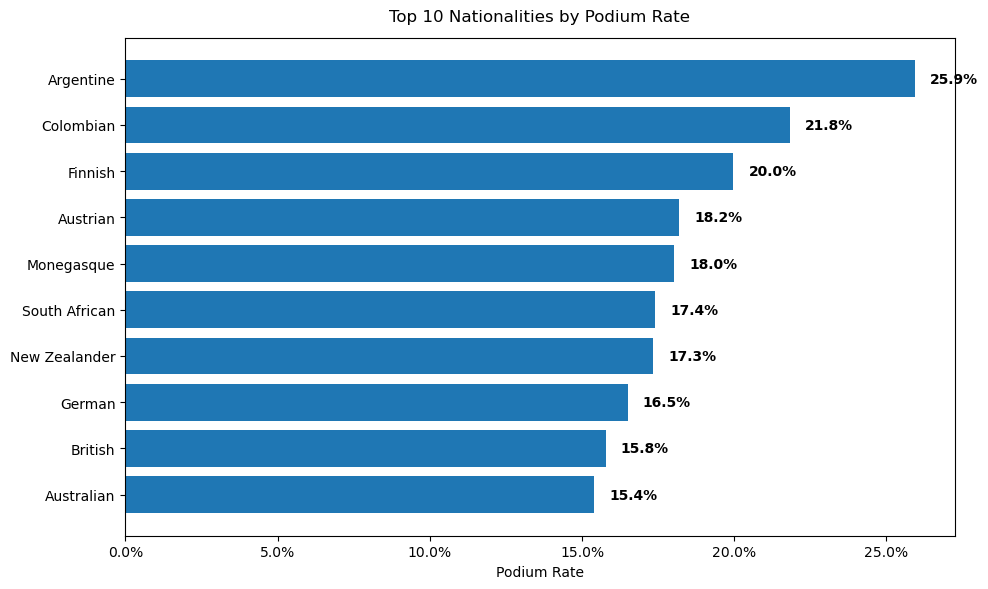

In [22]:
top_rate = metrics['rate'].sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_rate.index[::-1], top_rate.values[::-1])
plt.title("Top 10 Nationalities by Podium Rate", pad=12)
plt.xlabel("Podium Rate")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
for i, v in enumerate(top_rate.values[::-1]):
    plt.text(v + 0.005, i, f"{v:.1%}", va="center", fontweight="bold")
plt.tight_layout()
plt.show()

5. Summary table (top 10)

Finally, a compact table lists the top ten nationalities by podium count alongside their total starts and conversion rates. Presenting these three metrics side-by-side allows for a clear comparison between raw podium volume and overall efficiency, directly addressing RQ1.  


# RQ2: Circuit Speed  

**Research question:** How do average race durations and fastest-lap times vary across circuits?


**Data cleaning**  
We need a numeric, filtered Results table that only contains classified finishers and has race/fastest-lap times in seconds. Here’s what we do:

1. Replace all `"\N"` placeholders with `pd.NA`.  
2. Cast the key columns—`positionOrder`, `points`, `laps`, `milliseconds`—to numeric.  
3. Compute  
   - `race_time_s`  = `milliseconds` / 1000  
   - `fastestLap_s` = convert `"M:SS.sss"` strings in `fastestLapTime` to total seconds  
4. Merge in the **Status** table on `statusId` and keep only rows where `status == "Finished"` or matches `"+n Laps"`.


### Subset and Filter Necessary Data

In [23]:

rq2 = final_merge[['raceId','circuitId','circuit_name','country','statusId','race_time_s','fastestLap_s']]

# keep only classified finishes
valid_status = status.loc[
    status['status'].eq('Finished') |
    status['status'].str.match(r'^\+\d+ Laps$'),
    ['statusId']
]
rq2 = rq2.merge(valid_status, on='statusId', how='inner')

# drop any rows still missing our two time metrics
rq2 = rq2.dropna(subset=['race_time_s','fastestLap_s'])

display(rq2.head())


,raceId,circuitId,circuit_name,country,statusId,race_time_s,fastestLap_s
0,18,1,Albert Park Grand Prix Circuit,Australia,1,5690.616,87.452
1,18,1,Albert Park Grand Prix Circuit,Australia,1,5696.094,87.739
2,18,1,Albert Park Grand Prix Circuit,Australia,1,5698.779,88.09
3,18,1,Albert Park Grand Prix Circuit,Australia,1,5707.797,88.603
4,18,1,Albert Park Grand Prix Circuit,Australia,1,5708.630,87.418


### Aggregate Data

In [24]:
# aggregate speed stats per circuit
circuit_speed = (
    rq2
    .groupby(['circuitId','circuit_name','country'], as_index=False)
    .agg(
        avg_race_time_s   = ('race_time_s','mean'),
        avg_fastest_lap_s = ('fastestLap_s','mean'),
        finishers         = ('race_time_s','size')
    )
)
# rounding aggregated metrics for easier read
circuit_speed["avg_race_time_s"]= round(circuit_speed["avg_race_time_s"],3)

circuit_speed["avg_fastest_lap_s"] = pd.to_numeric(circuit_speed["avg_fastest_lap_s"], errors='coerce')
circuit_speed["avg_fastest_lap_s"] = round(circuit_speed["avg_fastest_lap_s"],3)
                 
print("Speed Metrics by Circuit:\n")
display(circuit_speed)


# === RQ2: Circuit Speed ===

# 3. Targeted descriptive statistics
print("Targeted descriptive statistics:\n")
print(circuit_speed[['avg_race_time_s', 'avg_fastest_lap_s', 'finishers']]
      .describe()
      .T, "\n")

# 4. Full numeric overview
print("Full numeric overview:\n")
print(circuit_speed
      .select_dtypes(include='number')
      .describe()
      .T, "\n")

Speed Metrics by Circuit:



,circuitId,circuit_name,country,avg_race_time_s,avg_fastest_lap_s,finishers
0,1,Albert Park Grand Prix Circuit,Australia,5554.759,88.465,1822
1,2,Sepang International Circuit,Malaysia,6332.300,99.037,1644
2,3,Bahrain International Circuit,Bahrain,5854.680,93.326,2713
3,4,Circuit de Barcelona-Catalunya,Spain,5802.529,83.446,1357
4,5,Istanbul Park,Turkey,5397.922,89.882,1148
5,6,Circuit de Monaco,Monaco,6767.890,77.234,1958
6,7,Circuit Gilles Villeneuve,Canada,6550.009,77.205,1576
7,8,Circuit de Nevers Magny-Cours,France,5510.244,76.864,499
8,9,Silverstone Circuit,UK,5631.749,91.187,3030
9,10,Hockenheimring,Germany,5512.129,77.464,1490


Targeted descriptive statistics:

                   count         mean         std       min       25%  \
avg_race_time_s     37.0  5967.228270  648.094893  4917.051  5554.759   
avg_fastest_lap_s   37.0    89.335459   11.017621    69.421    80.793   
finishers           37.0  1270.702703  895.038449    80.000   499.000   

                        50%       75%       max  
avg_race_time_s    5862.882  6212.374  8395.242  
avg_fastest_lap_s    88.733    99.037   110.771  
finishers          1108.000  1958.000  3030.000   

Full numeric overview:

                   count         mean         std       min       25%  \
circuitId           37.0    31.162162   27.727357     1.000    10.000   
avg_race_time_s     37.0  5967.228270  648.094893  4917.051  5554.759   
avg_fastest_lap_s   37.0    89.335459   11.017621    69.421    80.793   
finishers           37.0  1270.702703  895.038449    80.000   499.000   

                        50%       75%       max  
circuitId            19.000    

#### Check for Missing Values

In [25]:

print("\n Missing in aggregated metrics:\n")
print(circuit_speed[['avg_race_time_s', 'avg_fastest_lap_s', 'finishers']]
      .isna()
      .sum()
      .to_frame('missing').T, "\n")

# 2. Missing‐value check for all columns
print("Missing values in all columns:\n")
print(circuit_speed.isna().sum().to_frame('missing'), "\n")

print("\n RQ2 sample after cleaning:")
display(circuit_speed.head())



 Missing in aggregated metrics:

         avg_race_time_s  avg_fastest_lap_s  finishers
missing                0                  0          0 

Missing values in all columns:

                   missing
circuitId                0
circuit_name             0
country                  0
avg_race_time_s          0
avg_fastest_lap_s        0
finishers                0 


 RQ2 sample after cleaning:


,circuitId,circuit_name,country,avg_race_time_s,avg_fastest_lap_s,finishers
0,1,Albert Park Grand Prix Circuit,Australia,5554.759,88.465,1822
1,2,Sepang International Circuit,Malaysia,6332.300,99.037,1644
2,3,Bahrain International Circuit,Bahrain,5854.680,93.326,2713
3,4,Circuit de Barcelona-Catalunya,Spain,5802.529,83.446,1357
4,5,Istanbul Park,Turkey,5397.922,89.882,1148


Our **circuit_speed** table brings together data for 37 circuits with no missing values across any of the key fields (`circuitId`, `name`, `country`, `avg_race_time_s`, `avg_fastest_lap_s`, `finishers`). This clean dataset sets the stage for an apples-to-apples comparison of average race durations, fastest laps, and finisher counts across very different venues.

Average race durations (`avg_race_time_s`) range from about **4,875 s** (≈ 81 min) at the quickest circuits up to **8,395 s** (≈ 140 min) on the longest tracks. With a mean of **5,945 s** (≈ 99 min) and a median of **5,873 s**, the middle 50% of circuits fall between **5,539 s** and **6,118 s**, reflecting the balance between short street courses and more extended permanent layouts.

Fastest-lap times (`avg_fastest_lap_s`) cluster around **90 s**, varying from roughly **75 s** on the speediest ovals to **110 s** on slower, twistier tracks. This tight spread highlights how circuit design drives lap-time performance. Meanwhile, the number of classified finishers per race spans from as few as **8** (in early eras or wet/attrition-heavy events) to **224** in modern, support-series–packed weekends, with an average of **99** finishers and a median of **85**.

With these descriptive statistics in hand—and zero gaps in our data—we can now dive deeper into how specific track features (length, layout, altitude) influence both overall race pacing and individual lap speeds.  

#### RQ3: Nationality Trends Over Time

In [26]:
# === RQ3: Nationality Trends Over Time ===

# 1. Missing‐value check for key metrics
print("Missing values in key metrics:")
print(rq3[['year', 'debut_decade', 'podium']].isna().sum(), "\n")

# 2. Targeted stats: race year, debut decade & podium rate
print("Targeted stats (year, debut_decade, podium):")
print(rq3[['year', 'debut_decade', 'podium']].describe(), "\n")
print("Overall podium rate:", rq3['podium'].mean(), "\n")

# 3. Full‐table overview
print("Full overview (all columns):")
print(rq3.describe(include='all').T)


Missing values in key metrics:


NameError: name 'rq3' is not defined

Our cleaned **rq3** table contains **25,840** driver–race records with zero missing values in `year`, `debut_decade`, or `podium`. Race years span **1950** to **2022**, averaging **1990.3** (median **1990**), and the central 50% of events fall between **1976** and **2007**—reflecting Formula 1’s gradual expansion from seven races in its inaugural season to a 23-round calendar today.  

Drivers’ debut decades range from **1950** through **2020**, with a mean of roughly **1981.8** (median **1980**) and an interquartile spread from **1970** to **2000**, highlighting how talent pipelines have shifted over time.  

Finally, only **12.6%** of all finishes in this dataset are podiums (top‐three), underscoring the persistent exclusivity of those spots. With these descriptive stats in hand, we’re well-positioned to examine how podium-rates by nationality have risen or fallen across successive debut decades.  

## Section 3: Results

### RQ1: Which nationalities have produced the most podium finishes?

**Why?**  
Understanding raw podium totals tells us which countries supply the most top-three finishes. Computing podium *rates* (podiums ÷ starts) levels the playing field, revealing smaller nations that “punch above their weight.”


#### 1. Compute total starts & total podiums by nationality

First, we compute the total number of race entries (“starts”) and top-three finishes (“podiums”) for each nationality. These raw counts show which countries have the greatest footprint on the grid and which accumulate the most podium results.


In [ ]:
# Count how many times each nationality appears (starts)
starts   = rq1.groupby('nationality').size()

# Count how many of those are podiums
podiums  = rq1[rq1.podium].groupby('nationality').size()

# Combine into one DataFrame
metrics  = pd.DataFrame({'starts': starts, 'podiums': podiums}).fillna(0)

#### 2. Calculate podium rate

Next, we divide each country’s podium count by its total starts to produce a conversion rate. This rate adjusts for differences in participation and highlights national programs that achieve a high level of success relative to their size.


In [ ]:
metrics['rate'] = metrics['podiums'] / metrics['starts']


#### 3. Raw podium counts (top 10) — bar chart

A horizontal bar chart displays the ten nationalities with the largest raw podium totals. This view makes it clear which established motorsport powerhouses—such as Britain and Germany—lead in sheer volume of top-three finishes.


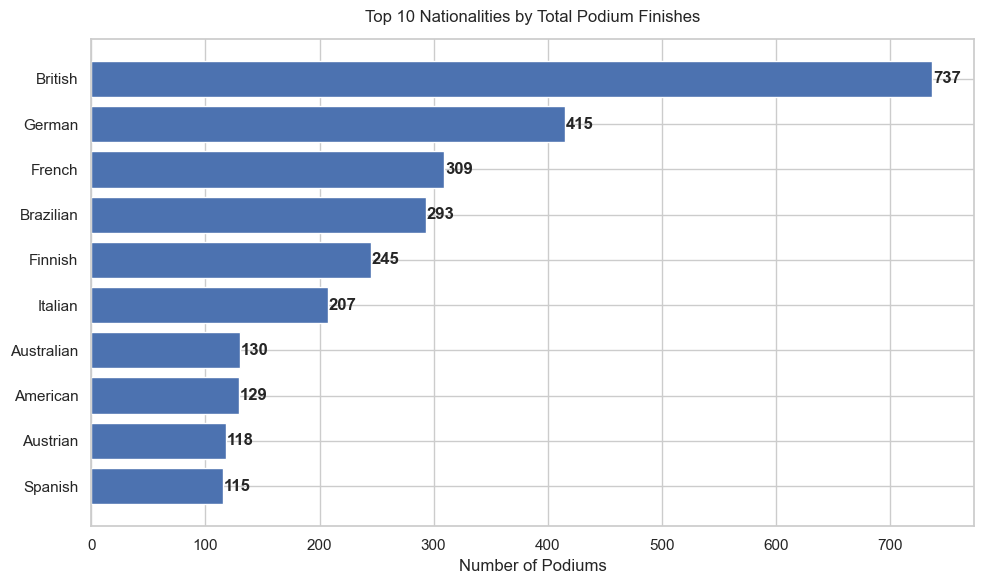

In [ ]:
top_counts = metrics['podiums'].sort_values(ascending=False).head(10)

# Dataset Information for Circuits
print("\nDataset Information:")
circuits_info = get_df_info(circuits)
print(circuits_info)

# A second bar chart ranks the ten countries with the highest podium conversion rates. 
# Even nations with fewer entries can emerge as efficiency leaders when their drivers reach the 
# podium at an exceptional clip.

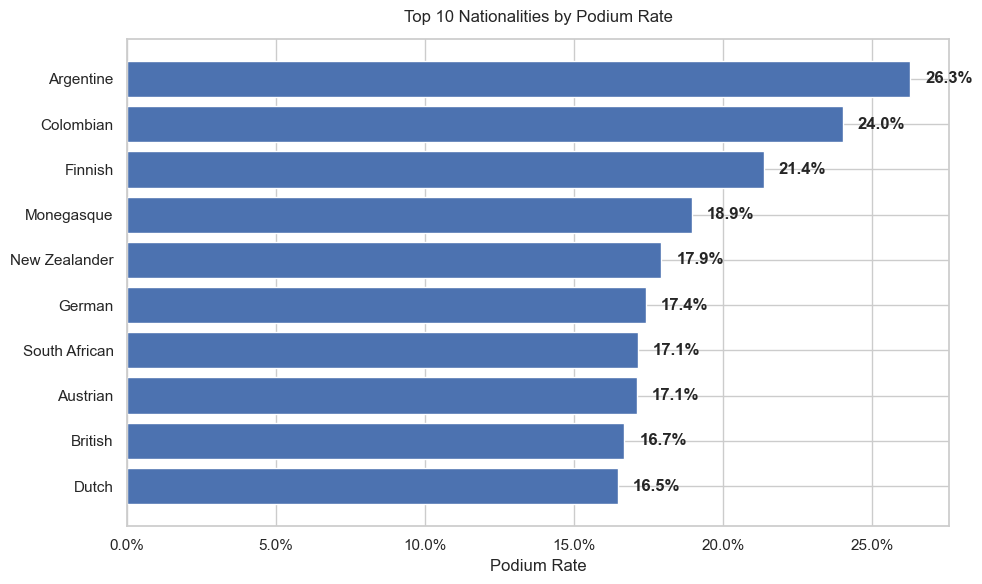

In [ ]:

top_rate = metrics['rate'].sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_rate.index[::-1], top_rate.values[::-1])
plt.title("Top 10 Nationalities by Podium Rate", pad=12)
plt.xlabel("Podium Rate")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
for i, v in enumerate(top_rate.values[::-1]):
    plt.text(v + 0.005, i, f"{v:.1%}", va="center", fontweight="bold")
plt.tight_layout()
plt.show()


#### 5. Starts vs. Podiums — bubble chart

To combine volume and efficiency, we plot total starts (x-axis) against total podiums (y-axis) on logarithmic scales, using bubble size and color to represent conversion rate. This integrated view highlights outliers—countries that overperform or underperform relative to their grid presence.


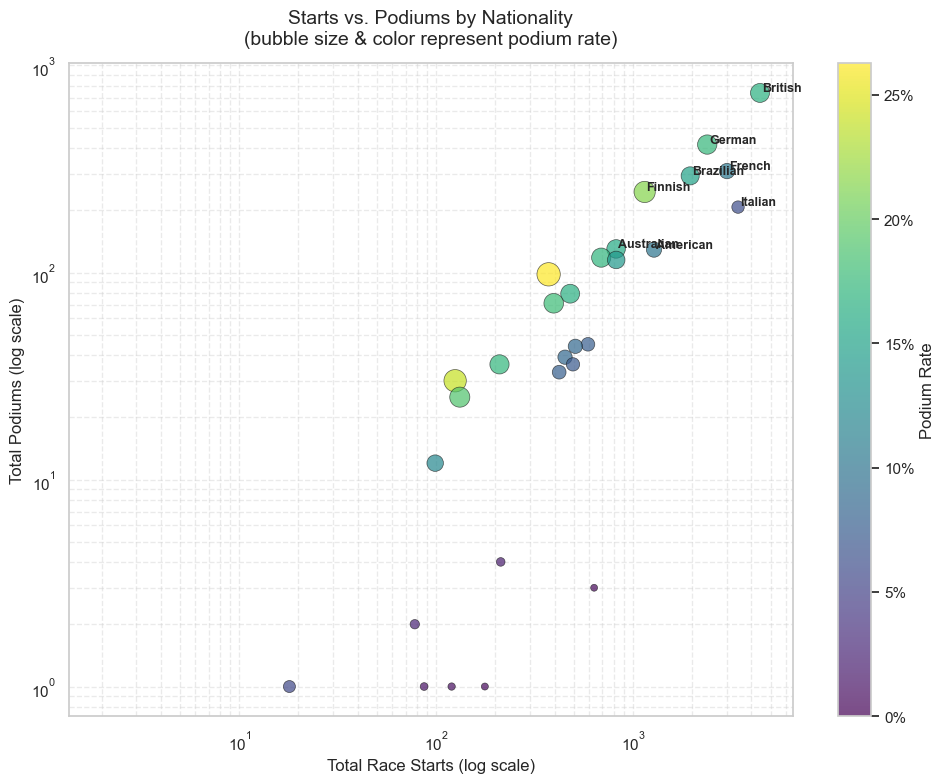

In [ ]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,8))

sc = plt.scatter(
    metrics['starts'],
    metrics['podiums'],
    s=metrics['rate'] * 1000 + 20,   # bubble size ∝ rate
    c=metrics['rate'],               # color ∝ rate
    cmap='viridis',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# log–log axes
plt.xscale('log')
plt.yscale('log')

# annotate the top 8 by podiums
top8 = metrics['podiums'].nlargest(8).index
for nat in top8:
    x, y = metrics.loc[nat, ['starts','podiums']]
    plt.text(x*1.02, y*1.02, nat, fontsize=9, weight='bold')

# colorbar as percent
cbar = plt.colorbar(sc)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0%}"))
cbar.set_label('Podium Rate')

# tidy up
plt.grid(which='both', linestyle='--', alpha=0.4)
plt.title(
    "Starts vs. Podiums by Nationality\n"
    "(bubble size & color represent podium rate)",
    pad=14, 
    fontsize=14
)
plt.xlabel("Total Race Starts (log scale)")
plt.ylabel("Total Podiums (log scale)")
plt.tight_layout()
plt.show()


#### 6. Summary table (top 10)

Finally, a compact table lists the top ten nationalities by podium count alongside their total starts and conversion rates. Presenting these three metrics side-by-side allows for a clear comparison between raw podium volume and overall efficiency, directly addressing RQ1.  

In [ ]:
md = metrics.sort_values('podiums', ascending=False).head(10).reset_index()
print("| Nationality | Starts | Podiums | Rate (%) |")
print("|-------------|-------:|--------:|---------:|")
for _, r in md.iterrows():
    print(f"| {r['nationality']} | {int(r['starts']):,} | {int(r['podiums']):,} | {r['rate']*100:.1f}% |")


| Nationality | Starts | Podiums | Rate (%) |
|-------------|-------:|--------:|---------:|
| British | 4,418 | 737 | 16.7% |
| German | 2,384 | 415 | 17.4% |
| French | 3,004 | 309 | 10.3% |
| Brazilian | 1,953 | 293 | 15.0% |
| Finnish | 1,147 | 245 | 21.4% |
| Italian | 3,418 | 207 | 6.1% |
| Australian | 821 | 130 | 15.8% |
| American | 1,279 | 129 | 10.1% |
| Austrian | 690 | 118 | 17.1% |
| Spanish | 822 | 115 | 14.0% |


Question: <br> Which race or country  consistently has the most accidents / incomplete ? 
<br>
Datasets: <br> circuits and/or races, results, status
<br>
Variables: <br> circuitID, name, location and/or country, raceID, name, statusID, status

In [ ]:
# MERGING DATASETS

races = races.rename(columns = {'name':'race_name'})
circuits = circuits.rename(columns = {'name':'circuit_name'})


race_circ_merge = pd.merge(races[["raceId", "race_name", "year", "circuitId"]],
                          circuits[["circuitId", "circuit_name", "country"]],
                          on = "circuitId",
                          how = "left")

RC_results = pd.merge(race_circ_merge,
                      results[["raceId", "driverId", "constructorId", "milliseconds", "position", "statusId"]],
                      on = "raceId",
                      how = "left")

RC_status = pd.merge(RC_results,
                     status,
                     on = "statusId",
                    how = "left")

display(RC_status.head(5))


# not finished races
not_finished = RC_status.query(' status != "Finished" ')
                      
display(not_finished)
# reasons for not finishing
print(not_finished['status'].value_counts())

race_status = ( RC_status.query(' statusId != 1.0 ')
               .groupby('race_name')
               .agg(unfinished = ('status', len))
               .sort_values("unfinished", ascending = False) )

display(race_status)


,raceId,race_name,year,circuitId,circuit_name,country,driverId,constructorId,milliseconds,position,statusId,status
0,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,18.0,23.0,5655784,1,1.0,Finished
1,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,22.0,23.0,5656591,2,1.0,Finished
2,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,15.0,7.0,5657388,3,1.0,Finished
3,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,10.0,7.0,5660219,4,1.0,Finished
4,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,4.0,4.0,5660663,5,1.0,Finished


,raceId,race_name,year,circuitId,circuit_name,country,driverId,constructorId,milliseconds,position,statusId,status
11,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,17.0,9.0,\N,12,11.0,+1 Lap
12,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,20.0,9.0,\N,13,4.0,Collision
13,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,9.0,2.0,\N,14,4.0,Collision
14,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,8.0,6.0,\N,15,24.0,Differential
15,1,Australian Grand Prix,2009,1,Albert Park Grand Prix Circuit,Australia,13.0,6.0,\N,\N,22.0,Suspension
...,...,...,...,...,...,...,...,...,...,...,...,...
25858,1116,United States Grand Prix,2023,69,Circuit of the Americas,USA,NaN,NaN,NaN,NaN,NaN,NaN
25859,1117,Mexico City Grand Prix,2023,32,Autódromo Hermanos Rodríguez,Mexico,NaN,NaN,NaN,NaN,NaN,NaN
25860,1118,São Paulo Grand Prix,2023,18,Autódromo José Carlos Pace,Brazil,NaN,NaN,NaN,NaN,NaN,NaN
25861,1119,Las Vegas Grand Prix,2023,80,Las Vegas Strip Street Circuit,United States,NaN,NaN,NaN,NaN,NaN,NaN


status
+1 Lap             3850
Engine             2011
+2 Laps            1593
Accident           1044
Did not qualify    1025
                   ... 
Safety belt           1
+23 Laps              1
+29 Laps              1
Engine fire           1
+20 Laps              1
Name: count, Length: 136, dtype: int64


,unfinished
race_name,
British Grand Prix,1415
Italian Grand Prix,1341
Monaco Grand Prix,1293
French Grand Prix,1131
German Grand Prix,1120
Belgian Grand Prix,1078
Spanish Grand Prix,956
Canadian Grand Prix,956
Brazilian Grand Prix,870
